# Computed MAF QC

The goal of the analysis is to see how many lead variants from credible sets had correctly calculated MAF.

<div class="alert alert-block alert-info"> 
<b> Reasons of MAF computation failure </b>
    <ul>
        <li><I>majorPopulationMAF == 0.0</I>  - Searched variant was found in gnomAD, but it was not reported for the searched study major population</li>
        <li><I>majorPopulationMAF is Null</I> -  Searched variant was not found in gnomAD, so AF was not reported for any population</li>
    </ul>

 </div>


## Data Loading

The data required for the analysis is loaded from the `computed maf` dataset.


In [2]:
import plotnine as pn
from gentropy.common.session import Session
from pyspark.sql import functions as f

from manuscript_methods import OpenTargetsTheme, break_string, group_statistics
from manuscript_methods.datasets import LeadVariantEffect
from manuscript_methods.maf import MinorAlleleFrequency, MinorAlleleFrequencyClassification, maf_discrepancies


In [3]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead_variant_effect_replicated"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/30 11:29:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/30 11:29:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
session.spark


In [5]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)


## MAF QC

Ensure that both datasets contain the same amount of rows


In [6]:
data = dataset_maf.df.select(maf_discrepancies(f.col("majorLdPopulationMaf.value")))

gs = group_statistics(data, [f.col("mafDiscrepancy")])
gs.show(truncate=False)


+------------------------------------------------+-------+-----+--------------------+
|mafDiscrepancy                                  |count  |%    |percentage          |
+------------------------------------------------+-------+-----+--------------------+
|Variant has allele frequency in gnomAD AF       |1724199|99.94|99.9448743587514    |
|Variant missing from major ancestry in gnomAD AF|534    |0.03 |0.030953830101730282|
|Variant missing from any ancestry in gnomAD AF  |417    |0.02 |0.024171811146856795|
+------------------------------------------------+-------+-----+--------------------+



### Plot the discrepances in MAF calculation


/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning:

Saving 5.35 x 4.5 in image.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning:

Filename: plots/01.2_discrepancies_in_maf_calculation.jpg



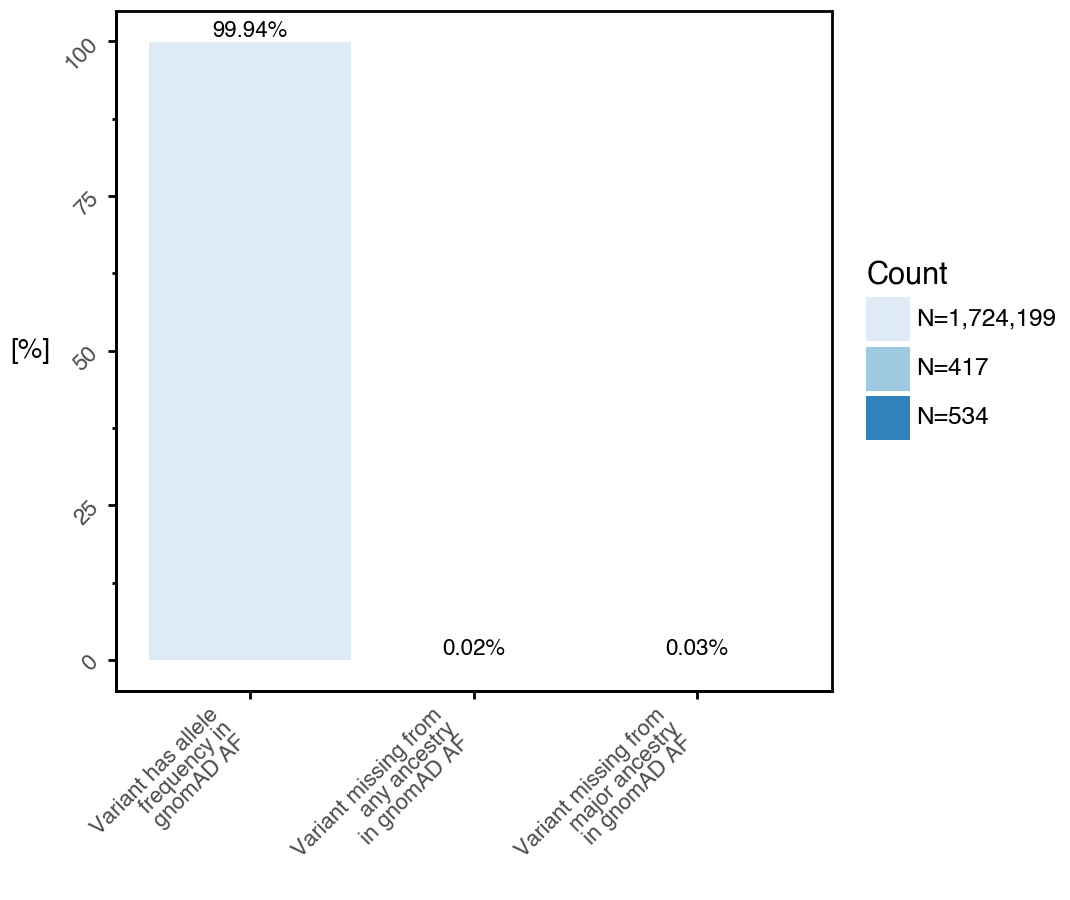

In [7]:
data = gs.toPandas()
data["mafDiscrepancy"] = data["mafDiscrepancy"].apply(break_string)
data["label"] = "N=" + data["count"].apply(lambda x: f"{x:,}")
p = (
    pn.ggplot(data=data, mapping=pn.aes(x="mafDiscrepancy", y="percentage", fill="label"))
    + pn.geom_col(stat="identity")
    + pn.labs(x="maf")
    + pn.scale_fill_brewer(type="seq")
    + OpenTargetsTheme.theme
    + pn.geom_text(
        pn.aes(label="%"),
        size=8,
        va="bottom",
        format_string="{}%",
    )
    + pn.labs(x="", y="[%]", fill="Count")
    + pn.theme(axis_title_y=pn.element_text(size=10, rotation=0))
)
p.save("plots/01.2_discrepancies_in_maf_calculation.jpg", dpi=300, bbox_inches="tight")
p


## Common vs Rare

The analysis was performed to see how many lead variants are falling into

- common (MAF > 0.01) and rare (MAF < 0.01) categories.

The analysis was perfromed on all credible set studyTypes


### Prepare the data


In [8]:
# Filter dataset to only include variants with a valid MAF value
filtered_maf_dataset = dataset_maf.maf_filter()

# Classify the minor allele frequency to common and rare variants
maf = MinorAlleleFrequency(f.col("majorLdPopulationMaf"))
maf_classification = MinorAlleleFrequencyClassification.from_maf(maf)
classified_dataset_maf = (
    filtered_maf_dataset.df.withColumn(maf_classification.name, maf_classification.col)
    .select("variantMAFClassification.*", "variantId", "studyStatistics.studyType")
    .melt(
        ids=["variantId", "studyType"],
        values=["common", "rare"],
        variableColumnName="mafClass",
        valueColumnName="mafValue",
    )
    .filter(f.col("mafValue"))
    .drop("mafValue")
)


### Check the number of common vs rare variants in all credible sets


In [9]:
gs = group_statistics(classified_dataset_maf, [f.col("mafClass"), f.col("studyType")])
gs.show()


+--------+----------+------+-----+--------------------+
|mafClass| studyType| count|    %|          percentage|
+--------+----------+------+-----+--------------------+
|  common|      eqtl|924305|53.61|   53.60779121203527|
|  common|     tuqtl|301176|17.47|  17.467589297987065|
|  common|      gwas|247032|14.33|  14.327348525315234|
|  common|      sqtl|167592| 9.72|   9.719991717893352|
|  common|    sceqtl| 34995| 2.03|   2.029638110218136|
|    rare|      eqtl| 20326| 1.18|   1.178866244557618|
|    rare|      gwas| 15976| 0.93|  0.9265751807070994|
|    rare|     tuqtl|  6738| 0.39|  0.3907901582125961|
|    rare|      sqtl|  3390| 0.20| 0.19661303596626606|
|  common|  cis-pqtl|  2099| 0.12| 0.12173768805108923|
|    rare|    sceqtl|   432| 0.03|0.025055112547913556|
|  common|trans-pqtl|   103| 0.01|0.005973788408414575|
|    rare|  cis-pqtl|    26| 0.00|0.001507946588531...|
|    rare|trans-pqtl|     9| 0.00|5.219815114148657E-4|
+--------+----------+------+-----+--------------

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning:

Saving 5.35 x 4.5 in image.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning:

Filename: plots/01.1_rare_vs_common_lead_variants.jpg



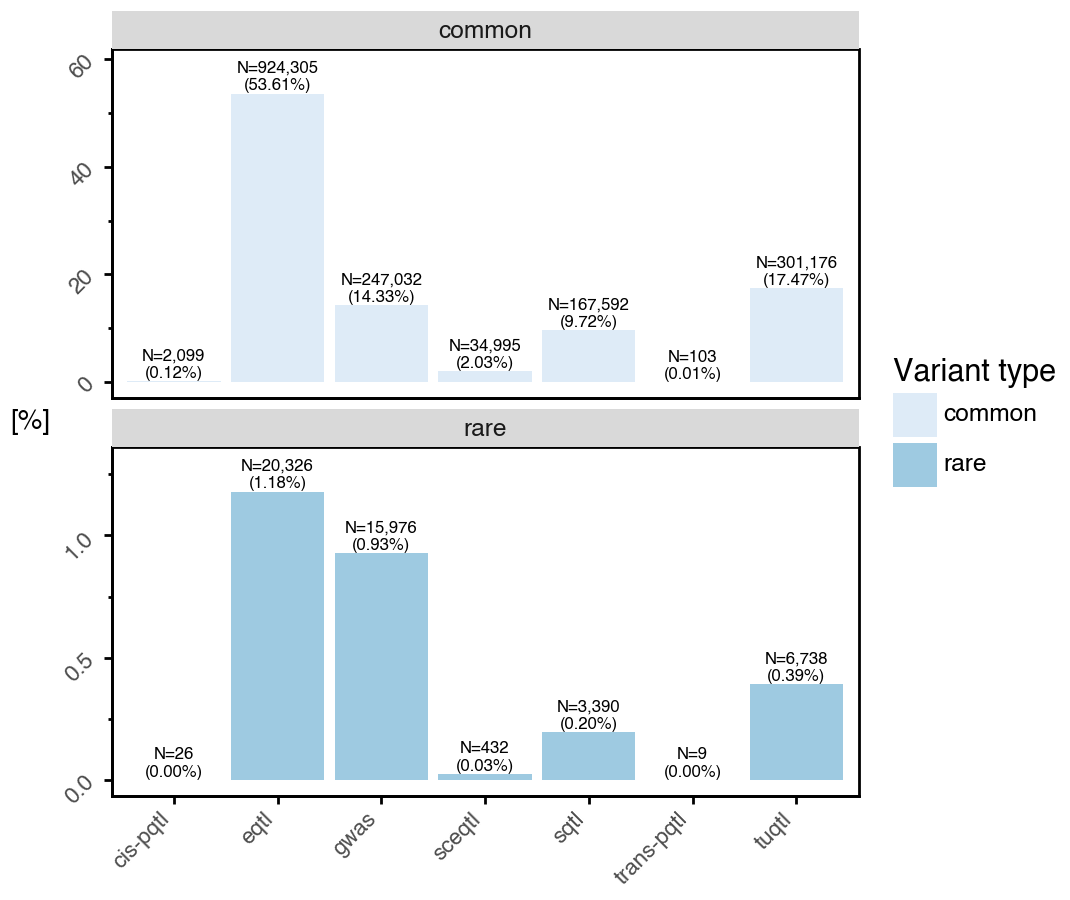

In [10]:
data = gs.orderBy("mafClass", f.desc("percentage")).toPandas()
data["label"] = "N=" + data["count"].apply(lambda x: f"{x:,}") + "\n(" + data["%"] + "%)"
data["y_lab_lim"] = data["percentage"] * 1.1  # place label 10% above highest bar in facet
# This plot works on non-aggregated data, all aggregations are done by plotnine
plt = (
    pn.ggplot(data, pn.aes(x="studyType", y="percentage", fill="mafClass"))
    + pn.geom_col()
    + pn.facet_wrap(facets="mafClass", nrow=2, scales="free_y")
    + pn.labs(x="", y="[%]", fill="Variant type")
    + pn.scale_fill_brewer()
    + OpenTargetsTheme.theme
    + pn.geom_text(
        pn.aes(y="y_lab_lim", label="label"),
        position=pn.position_stack(vjust=0.91),
        size=6,
        va="bottom",
    )
)
plt.save("plots/01.1_rare_vs_common_lead_variants.jpg", dpi=300, bbox_inches="tight")
plt
